# Try to apply neural network to F=ma and full state estimation again...

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.signal import chirp
from functools import partial # Import this due to weird lambda behavior
import system_dynamics
import networks
%load_ext tensorboard

## Training data generation

In [34]:
# from importlib import reload
reload(system_dynamics)
reload(networks)

<module 'networks' from '/Users/zz/Documents/GT 20X/phml/NN_toy_examples/networks.py'>

In [40]:
t0 = 0
t1 = 20
dt = 0.01
ts_steps = np.arange(t0, t1, dt)
ts_longer = np.arange(t0, t1, 5*dt)
u_func_list = [
    # High-freq inputs
    partial(chirp, f0=0.9, f1=1.1, t1=1),
    partial(chirp, f0=0.5, f1=1.4, t1=1),
    lambda t : np.sin(0.1*t+0.2),
    interp1d( ts_steps, np.random.normal(0, 2, ts_steps.shape), fill_value="extrapolate", kind='cubic'),
    interp1d( ts_steps, np.random.normal(0, 5, ts_steps.shape), fill_value="extrapolate", kind='cubic'),
    # Low-freq inputs
    partial(chirp, f0=0.2, f1=0.5, t1=1),
    lambda t : np.sin(0.04*t+1.2),
    interp1d( ts_longer, np.random.normal(0, 0.2, ts_longer.shape), fill_value="extrapolate", kind='cubic'),
    interp1d( ts_longer, np.random.normal(0, 0.5, ts_longer.shape), fill_value="extrapolate", kind='cubic')
]
duffing_sys = system_dynamics.DuffingFullState(t0=t0, tf=t1, dt=dt, noise=0)
duffing_sys_finer = system_dynamics.DuffingFullState(t0=t0, tf=t1, dt=dt/10, noise=0)
fma_sys = system_dynamics.Fma(t0=t0, tf=t1, dt=dt, noise=0)
fma_sys_finer = system_dynamics.Fma(t0=t0, tf=t1, dt=dt/10, noise=0)
# Make some data generation input functions
duffing_sys.add_u_func( u_func_list )
duffing_sys_finer.add_u_func( u_func_list )
fma_sys.add_u_func( u_func_list )
fma_sys_finer.add_u_func( u_func_list )

u_names = ['Chirp_thin', 'chirp_wide', 'sin','rand_var2','rand_var5', 'chirp_slow','sin_slow','rand_var2_slow', 'rand_var5_slow']

# Generate data
duffing_sys.data_generator()
duffing_sys_finer.data_generator()
fma_sys.data_generator()
fma_sys_finer.data_generator()

## Plot the generated data for visual inspection

In [ ]:
fig,axs = duffing_sys.plot_dataset(title='Training and test data', plot_skip_rate=1)

In [ ]:
fig,axs = fma_sys.plot_dataset(title='Training and test data', plot_skip_rate=1)

## Generate a bunch of neural nets for learning

In [41]:
# Set up nets
tf.keras.backend.clear_session()
seed = 2020
opt_alg = 'sgd'

# F=ma nets
sys_dym = fma_sys
log_root_dir = 'Fma_logs/'
input_mask = [1,3] # Give: u-3, v-1, x-2, t-0
fnet_25 = networks.NN_Dense(
    sys_dym, input_mask, seed=seed, log_dir=log_root_dir+'2-5',  tensorboard=True,
    Nlayer=2, Nneuron=5, activation='tanh', optimizer=opt_alg)
fnet_22 = networks.NN_Dense(
    sys_dym, input_mask, seed=seed, log_dir=log_root_dir+'2-2', 
    Nlayer=2, Nneuron=2, activation='tanh', optimizer=opt_alg)
fnet_42 = networks.NN_Dense(
    sys_dym, input_mask, seed=seed, log_dir=log_root_dir+'4-2', 
    Nlayer=4, Nneuron=2, activation='tanh', optimizer=opt_alg)
fnet_44 = networks.NN_Dense(
    sys_dym, input_mask, seed=seed, log_dir=log_root_dir+'4-4', 
    Nlayer=4, Nneuron=4, activation='tanh', optimizer=opt_alg)
net_list = [fnet_25, fnet_22, fnet_42, fnet_44]
net_names = ['2-5','2-2','4-2','4-4']

# Finer duffing nets
sys_dym = duffing_sys_finer
log_root_dir = 'Duffing_logs_finer/'
input_mask = [1,3]
opt_alg = 'adam'
dnet_25 = networks.NN_Dense(
    sys_dym, input_mask, seed=seed, log_dir=log_root_dir+'2-5',  tensorboard=True,
    Nlayer=2, Nneuron=5, activation='tanh', optimizer=opt_alg)
dnet_22 = networks.NN_Dense(
    sys_dym, input_mask, seed=seed, log_dir=log_root_dir+'2-2', 
    Nlayer=2, Nneuron=2, activation='tanh', optimizer=opt_alg)
dnet_42 = networks.NN_Dense(
    sys_dym, input_mask, seed=seed, log_dir=log_root_dir+'4-2', 
    Nlayer=4, Nneuron=2, activation='tanh', optimizer=opt_alg)
dnet_44 = networks.NN_Dense(
    sys_dym, input_mask, seed=seed, log_dir=log_root_dir+'4-4', 
    Nlayer=4, Nneuron=4, activation='tanh', optimizer=opt_alg)
net_list += [dnet_25, dnet_22, dnet_42, dnet_44]
net_names += ['2-5','2-2','4-2','4-4']

# Construct models
for nn in net_list:
    nn.construct()


In [70]:
for nn in net_list[4:]:
    nn.set_input_mask([2,3])

In [72]:
# Train models. 
Epoch = 40
for nn in net_list[4:]:
    nn.train(epoch=Epoch, inds=[3,4])
    nn.summary()

Train on 39998 samples
Epoch 1/40
39998/39998 [==============================] - 2s 47us/sample - loss: 0.0681
Epoch 2/40
39998/39998 [==============================] - 1s 32us/sample - loss: 0.0301
Epoch 3/40
39998/39998 [==============================] - 2s 38us/sample - loss: 0.0282
Epoch 4/40
39998/39998 [==============================] - 2s 38us/sample - loss: 0.0277
Epoch 5/40
39998/39998 [==============================] - 1s 33us/sample - loss: 0.0275
Epoch 6/40
39998/39998 [==============================] - 2s 45us/sample - loss: 0.0273
Epoch 7/40
39998/39998 [==============================] - 2s 39us/sample - loss: 0.0271
Epoch 8/40
39998/39998 [==============================] - 1s 34us/sample - loss: 0.0270
Epoch 9/40
39998/39998 [==============================] - 2s 40us/sample - loss: 0.0269
Epoch 10/40
39998/39998 [==============================] - 2s 57us/sample - loss: 0.0269
Epoch 11/40
39998/39998 [==============================] - 1s 37us/sample - loss: 0.0268
Epoch 1

In [58]:
# Save models
for i in range(len(net_list)):
    net_list[i].save(net_names[i]+'-models{0}'.format(i))

INFO:tensorflow:Assets written to: 2-5-models0/model/assets
INFO:tensorflow:Assets written to: 2-2-models1/model/assets
INFO:tensorflow:Assets written to: 4-2-models2/model/assets
INFO:tensorflow:Assets written to: 4-4-models3/model/assets
INFO:tensorflow:Assets written to: 2-5-models4/model/assets
INFO:tensorflow:Assets written to: 2-2-models5/model/assets
INFO:tensorflow:Assets written to: 4-2-models6/model/assets
INFO:tensorflow:Assets written to: 4-4-models7/model/assets


In [5]:
# Or load existing models
for i in range(len(net_list)):
    net_list[i].load(net_names[i]+'-models{0}/model'.format(i))

ValueError: not enough values to unpack (expected 2, got 1)

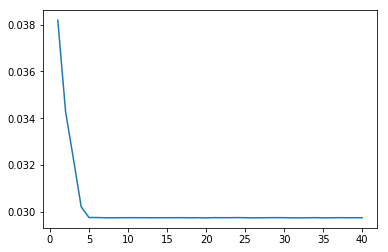

In [73]:
fig,axs = net_list[6].plot_loss_history()

In [ ]:
# Above: Loss history for 4-2. X axis is epoch.

## Validation and testing

In [ ]:
# Additional training, if needed
# net_list[3].train(epoch=Epoch, inds=[0])

In [74]:
test_selection = [0,1,2,3,4,5,6,7,8]
results_list = [nn.test(inds=test_selection) for nn in net_list]
# Notice: Prediction size is (N,1), while output size is (N,1,1). Problem averted using squeeze=True

In [9]:
error_g = np.square(results_list[0][0][0] - results_list[0][1][0])
error_g.shape

(1999, 2)

Text(0.5, 0.98, 'F=ma when given <u,v> as training input, after 1200 SGD epochs (no momentum)\n\n')

<Figure size 432x288 with 0 Axes>

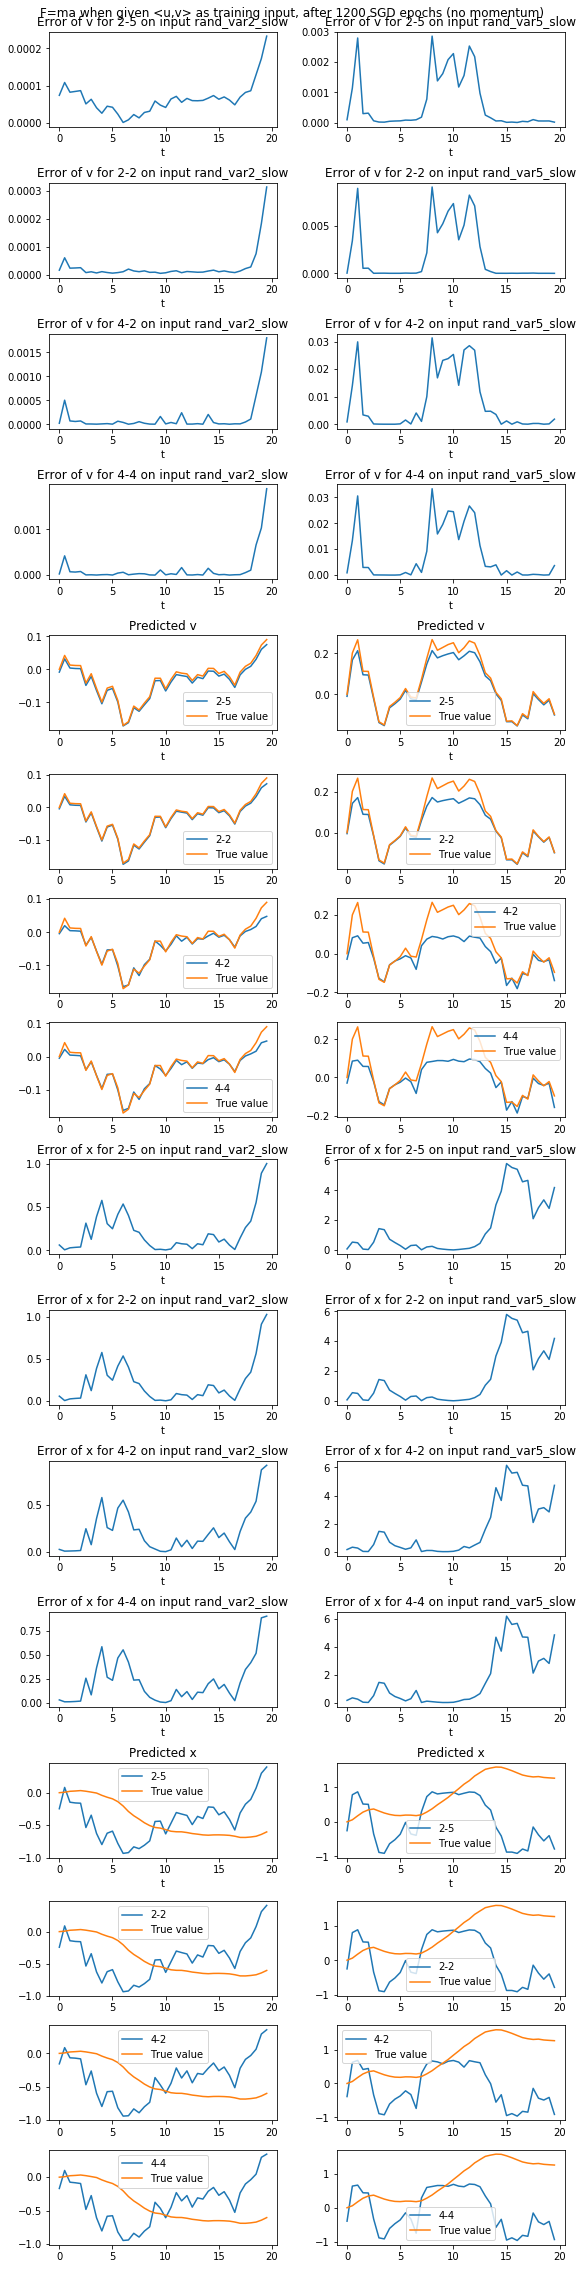

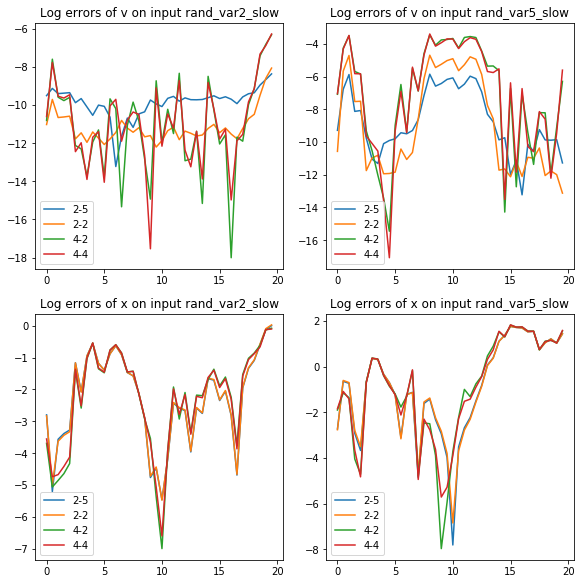

In [28]:
# F=ma:
plt.clf()
Nrow = 2 * 4 * 2
dataset_inds = [7,8]
Ncol = len(dataset_inds)
fig,axs = plt.subplots(Nrow, Ncol, constrained_layout=True, figsize = (Ncol*4,Nrow*2), squeeze=False)
figt,axst = plt.subplots(2, Ncol, constrained_layout=True, figsize = (Ncol*4,2*4))
plot_skip_rate = 50
for j in range(len(dataset_inds)):
    jj = dataset_inds[j]
    time_series = results_list[0][2][jj][:,0,-1] # [:,0,-1] means take all frames(:), first row (0), latest value (-1)
    for n in range(4):
        # Plot error between correct answer and prediction
        error_g = np.square(results_list[n][0][jj] - results_list[n][1][jj])
        axs[n][j].plot(time_series[::plot_skip_rate], error_g[::plot_skip_rate,0])
        axs[n][j].set_title('Error of v for '+net_names[n]+' on input '+u_names[jj])
        axs[n][j].set_xlabel('t')
        axs[n+4][j].plot(time_series[::plot_skip_rate], results_list[n][0][jj][::plot_skip_rate,0])
        axs[n+4][j].plot(time_series[::plot_skip_rate], results_list[n][1][jj][::plot_skip_rate,0])
        axs[n+4][j].legend([net_names[n]]+['True value'])
        axs[n+8][j].plot(time_series[::plot_skip_rate], error_g[::plot_skip_rate,1])
        axs[n+8][j].set_title('Error of x for '+net_names[n]+' on input '+u_names[jj])
        axs[n+8][j].set_xlabel('t')
        axs[n+12][j].plot(time_series[::plot_skip_rate], results_list[n][0][jj][::plot_skip_rate,1])
        axs[n+12][j].plot(time_series[::plot_skip_rate], results_list[n][1][jj][::plot_skip_rate,1])
        axs[n+12][j].legend([net_names[n]]+['True value'])
        axst[0][j].plot(time_series[::plot_skip_rate], np.log(error_g[::plot_skip_rate,0]))
        axst[1][j].plot(time_series[::plot_skip_rate], np.log(error_g[::plot_skip_rate,1]))
    axs[4][j].set_title('Predicted v')
    axs[4][j].set_xlabel('t')
    axs[12][j].set_title('Predicted x')
    axs[12][j].set_xlabel('t')
    axst[0][j].set_title('Log errors of v on input '+u_names[jj])
    axst[0][j].legend(net_names[:4])
    axst[1][j].set_title('Log errors of x on input '+u_names[jj])
    axst[1][j].legend(net_names[:4])
fig.suptitle('F=ma when given <u,v> as training input, after 1200 SGD epochs (no momentum)\n\n')

Text(0.5, 0.98, 'Performance when given <u,x> as training input, after 40 adam epochs (no momentum)\n\n')

<Figure size 432x288 with 0 Axes>

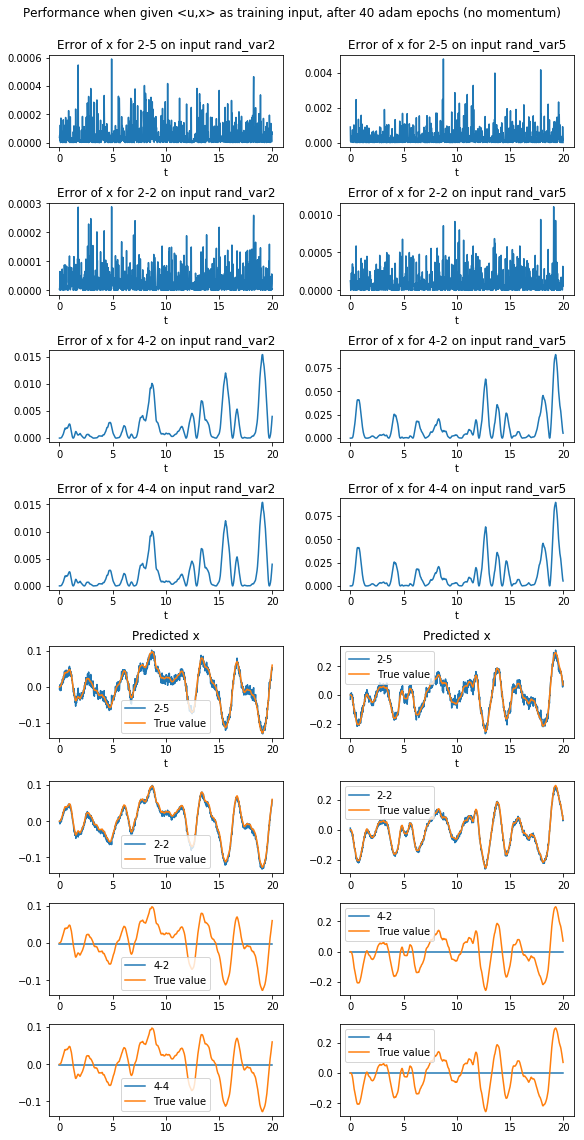

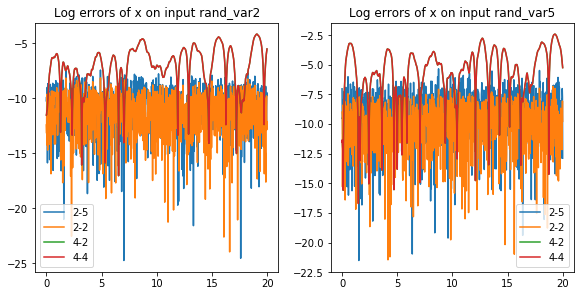

In [77]:
# Duffing, finer, WITH FULL STATE AS ITS OUTPUT:
#### To-do: Modify this script to allow multiple outputs
# Or just manually plot each output one by one.
plt.clf()
output_ind = 1
output_name_list = ['v','x']
net_list_inds = [4,5,6,7]
Nrow = 2 * len(net_list_inds)
dataset_inds = [3,4]
Ncol = len(dataset_inds)
fig,axs = plt.subplots(Nrow, Ncol, constrained_layout=True, figsize = (Ncol*4,Nrow*2), squeeze=False)
figt,axst = plt.subplots(1, Ncol, constrained_layout=True, figsize = (Ncol*4,4*1))
plot_skip_rate = 20
for j in range(len(dataset_inds)):
    jj = dataset_inds[j]
    time_series = results_list[-1][2][jj][:,0,-1] # [:,0,-1] means take all frames(:), first row (0), latest value (-1)
    for n in net_list_inds:
        # Plot error between correct answer and prediction
        error_g = np.square(results_list[n][0][jj] - results_list[n][1][jj])
        axs[n-4][j].plot(time_series[::plot_skip_rate], error_g[::plot_skip_rate,output_ind]) # 4 is a magic number here
        axs[n-4][j].set_title('Error of '+output_name_list[output_ind]+' for '+net_names[n]+' on input '+u_names[jj])
        axs[n-4][j].set_xlabel('t') # Change "4" and the "n " below for different applications
        axs[n][j].plot(time_series[::plot_skip_rate], results_list[n][0][jj][::plot_skip_rate,output_ind])
        axs[n][j].plot(time_series[::plot_skip_rate], results_list[n][1][jj][::plot_skip_rate,output_ind])
        axs[n][j].legend([net_names[n]]+['True value'])
        axst[j].plot(time_series[::plot_skip_rate], np.log(error_g[::plot_skip_rate,output_ind]))
    axs[len(net_list_inds)][j].set_title('Predicted '+output_name_list[output_ind])
    axs[len(net_list_inds)][j].set_xlabel('t')
    axst[j].set_title('Log errors of '+ output_name_list[output_ind] +' on input '+u_names[jj])
    axst[j].legend(net_names)
fig.suptitle('Performance when given <u,x> as training input, after 40 adam epochs (no momentum)\n\n')

In [17]:
a[0:10:2]

array([0, 2, 4, 6, 8])

In [12]:
a[(slice(None),1,slice(None),slice(None))]

array([[[ 6,  7],
        [ 8,  9],
        [10, 11]],

       [[18, 19],
        [20, 21],
        [22, 23]]])

In [55]:
def framing_helper(data, framelen, interv=1, stride=1, axis=1, offset=0):
    # Helper method for framing. Handles more general cases.
    # Puts a data into multiple frames.
    # framelen: Length of each frame
    # interv  : Number of samples between each frame
    # stride  : How many sample to go between two neighboring samples in a frame
    # axis    : Axis that's being framed
    # Example: Input is data=[1,2,3,4,5,6,7], N=3, interv=2, stride=1, then
    # output would be [ [1,2,3], [3,4,5], [5,6,7] ].
    Nframes = int(np.ceil( (data.shape[axis] - (framelen-1)*stride - offset) / interv ))
    set_inds = [slice(None)]*data.ndim # https://stackoverflow.com/questions/42656930/numpy-assignment-like-numpy-take
    take_inds = set_inds[:]
    frames = np.zeros( tuple( [Nframes] + list(data.shape[:axis]) + [framelen] + list(data.shape[axis+1:] ) ) )
    print(frames.shape)
    for i in range(Nframes):
        set_inds[axis] = i
        take_inds[axis] = slice( i*interv+offset, i*interv+framelen*stride+offset, stride )
        print(tuple(take_inds))
        print(data[tuple(take_inds)])
        frames[i] = data[tuple(take_inds)]

    return frames

def delay_embed(Inputset, Outputset, dt_int, de):
    # As of now, we assume that:
    # 1) dt_int is an integer specifying the delay as the number of dts.
    #    Currently don't support intervals that aren't integer multiples of dt.
    # 2) de is a provided embedding dimension.
    #    Might consider implementing FalseNN for automatic de detection later.
    # 3) This implementation, by default, assumes that:
    #    - The caller wants to know the embedding at any instant;
    #    - The caller wants to learn the relationship between embedding and some
    #      specific output value (not an embedding, but only a slice).
    #      If the output should be an embedding, create a subclass and overwrite dis.
    dembed_in = []
    dembed_out = []
    for i in range(len(Inputset)):
        dembed_in.append( framing_helper(Inputset[i], de, interv=dt_int) )
        # If outputset is going to only include a scalar value for each frame...
        # Then keep the same stride, and our input would have to start from the first scalar instead.
        dembed_out.append( framing_helper(Outputset[i], 1, interv=dt_int, offset=de-1) )
    return (dembed_in, dembed_out)


In [56]:

# a = np.arange(0,96,1).reshape((8,12))
# b = framing_helper(a, 3, 2, 1, 1)

c,d = delay_embed( [a], [a[0:1]], 5, 4 )
print(c)
print(d)

(2, 8, 4)
(slice(None, None, None), slice(0, 4, 1))
[[ 0  1  2  3]
 [12 13 14 15]
 [24 25 26 27]
 [36 37 38 39]
 [48 49 50 51]
 [60 61 62 63]
 [72 73 74 75]
 [84 85 86 87]]
(slice(None, None, None), slice(5, 9, 1))
[[ 5  6  7  8]
 [17 18 19 20]
 [29 30 31 32]
 [41 42 43 44]
 [53 54 55 56]
 [65 66 67 68]
 [77 78 79 80]
 [89 90 91 92]]
(2, 1, 1)
(slice(None, None, None), slice(4, 5, 1))
[[4]]
(slice(None, None, None), slice(9, 10, 1))
[[9]]
[array([[[ 0.,  1.,  2.,  3.],
        [12., 13., 14., 15.],
        [24., 25., 26., 27.],
        [36., 37., 38., 39.],
        [48., 49., 50., 51.],
        [60., 61., 62., 63.],
        [72., 73., 74., 75.],
        [84., 85., 86., 87.]],

       [[ 5.,  6.,  7.,  8.],
        [17., 18., 19., 20.],
        [29., 30., 31., 32.],
        [41., 42., 43., 44.],
        [53., 54., 55., 56.],
        [65., 66., 67., 68.],
        [77., 78., 79., 80.],
        [89., 90., 91., 92.]]])]
[array([[[4.]],

       [[9.]]])]


In [45]:
b

array([[[ 0.,  1.,  2.],
        [12., 13., 14.],
        [24., 25., 26.],
        [36., 37., 38.],
        [48., 49., 50.],
        [60., 61., 62.],
        [72., 73., 74.],
        [84., 85., 86.]],

       [[ 2.,  3.,  4.],
        [14., 15., 16.],
        [26., 27., 28.],
        [38., 39., 40.],
        [50., 51., 52.],
        [62., 63., 64.],
        [74., 75., 76.],
        [86., 87., 88.]],

       [[ 4.,  5.,  6.],
        [16., 17., 18.],
        [28., 29., 30.],
        [40., 41., 42.],
        [52., 53., 54.],
        [64., 65., 66.],
        [76., 77., 78.],
        [88., 89., 90.]],

       [[ 6.,  7.,  8.],
        [18., 19., 20.],
        [30., 31., 32.],
        [42., 43., 44.],
        [54., 55., 56.],
        [66., 67., 68.],
        [78., 79., 80.],
        [90., 91., 92.]],

       [[ 8.,  9., 10.],
        [20., 21., 22.],
        [32., 33., 34.],
        [44., 45., 46.],
        [56., 57., 58.],
        [68., 69., 70.],
        [80., 81., 82.],
        [92., 93.